CT volume stitching

Prepration: first need to find out roughly which slice coressponding to which slice before image registration

In [1]:
import numpy as np
import cv2
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import ORB, match_descriptors
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import EuclideanTransform
from skimage.transform import warp
from skimage.transform import match_histograms

In [2]:
def load_images_from_folder(folder):
    """
    read image from folder
    """
    images = []
    for filename in os.listdir(folder):
        f = os.path.join(folder,filename)
        img =cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

def prepare_data(path_left, path_right):
    """
    prepare data to the correct shape 
    """
    data_left = load_images_from_folder(path_left)
    data_right = load_images_from_folder(path_right)

    data_left = np.swapaxes(data_left,1, 2)
    data_right = np.swapaxes(data_right,1, 2)
    
    s_left = np.shape(data_left)
    s_right = np.shape(data_right)
    
    dif_n_row = s_left[0] - s_right[0] # different in number of row
    if dif_n_row<0: # if right image has more row than the left image
        data_right=np.delete(data_right, -dif_n_row, 0)
        
    if dif_n_row>0: # if right image has less row than the left image
        data_left=np.delete(data_left, dif_n_row, 0)   
        
    print ('left image has size:', np.shape(data_left))
    print ('right image has size:', np.shape(data_right))
    
    return(data_left, data_right)

def find_corresponding_index(data_left, data_right, left_index, right_index, figsize = (2,5)):
    """
    Manual prealigment: find the index in the left image that correspond to 
    the index in the right image by comparing the image slices
    
    parameters:
    -----------------------------------------------
    data_left: 3D data of the left volumn,
    data_right: 3D data of the right volumn,
    left_index: index in the left volumn
    right_index: index in the right volumn
    figsize: size of the figure to show the paired images
    """
    left_index = 33
    right_index = 40

    image0 = data_left[:,-100:,left_index]
    image1 = data_right[:,1:100,right_index] # remove the first pixel
    
    fig, axs = plt.subplots(1,2, figsize = (10,5))
    
    axs[0].imshow(data_left[:,:,left_index], cmap = 'gray')
    axs[1].imshow(data_right[:,:,right_index], cmap = 'gray')

    fig, axs = plt.subplots(1,2, figsize = figsize)
    axs[0].imshow(image0, cmap = 'gray')
    axs[1].imshow(image1, cmap = 'gray')
    return (image0, image1)
    
def histogram_matching(image_left, image_right, verbose = 1):
    """
    Match the histogram of the left image to the right image and output the normalized left image
    verbose: if to show the figures of the histogram before and after normalization
    """
    image = image_left
    reference = image_right
    matched = match_histograms(image, reference, multichannel=False)
    
    if verbose:
        plt.figure(figsize = (10,2))
        ax1 = plt.subplot(121)
        sns.distplot(image_left.ravel(),ax=ax1)
        plt.title('histogram of the left image before normalization')
        ax2 = plt.subplot(122)
        sns.distplot(image_right.ravel(),ax=ax2)
        plt.title('histogram of the right image normalization')

        plt.figure(figsize = (10,2))
        ax1 = plt.subplot(121)
        sns.distplot(reference.ravel(),ax=ax1)
        plt.title('histogram of the left image after normalization')
        
    return(matched.astype(np.uint8))

def image_registration(image_left, image_right, verbose = 1):
    """
    use ORB to extract keypoints of left and right images
    then use RANSAC to remove inliers to achieve succesful image registration 
    """
    
    orb = ORB(n_keypoints=1000)
    orb.detect_and_extract(image_left)
    keypoints1 = orb.keypoints
    descriptors1 = orb.descriptors

    orb.detect_and_extract(image_right)
    keypoints2 = orb.keypoints
    descriptors2 = orb.descriptors

    matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
    
   
    # Select keypoints from the source (image to be registered)
    # and target (reference image)
    src = keypoints2[matches12[:, 1]][:, ::-1]
    dst = keypoints1[matches12[:, 0]][:, ::-1]

    model_robust, inliers = ransac((src, dst), EuclideanTransform,
                                   min_samples=2, max_trials = 10000, residual_threshold=5, random_state = 20)

    if verbose:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))
        plot_matches(ax1, image_left, image_right, keypoints1, keypoints2, matches12)
        ax1.set_title('all matching points')
        ax1.axis('off');
        plot_matches(ax2, image_left, image_right, keypoints1, keypoints2, matches12[inliers])
        ax2.set_title('correct matching points')
        ax2.axis('off');
        
    return (model_robust)


def merge_small_img(image0, image1, model_robust, verbose = 1):
    """
    stitch image0 and image1 based on model_robust
    """
    #from skimage.transform import SimilarityTransform

    r, c = image1.shape[:2]

    # Note that transformations take coordinates in (x, y) format,
    # not (row, column), in order to be consistent with most literature
    corners = np.array([[0, 0],
                        [0, r],
                        [c, 0],
                        [c, r]])

    # Warp the image corners to their new positions
    warped_corners = model_robust(corners) # also include rotation
    #offset = model_robust(np.zeros(2)) # only do translation move
    #warpped_corners = corners + offset
    
    # Find the extents of both the reference image and the warped
    # target image
    all_corners = np.vstack((warped_corners, corners))

    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)

    output_shape = (corner_max - corner_min)
    output_shape = np.ceil(output_shape[::-1])

    offset = EuclideanTransform(translation=-corner_min)
    image0_ = warp(image0, offset.inverse,
                   output_shape=output_shape, cval=-1)
    image1_ = warp(image1, (model_robust + offset).inverse,
                   output_shape=output_shape, cval=-1)
    
    image_merge = np.where(image0_ == -1, image1_,image0_)

    if verbose:
        plt.figure(figsize = (5,5))
        ax1 = plt.subplot(131)
        plt.imshow(image0_,cmap = 'gray')
        ax2 = plt.subplot(132)
        plt.imshow(image1_,cmap = 'gray')

        plt.subplot(133)
        plt.imshow(image_merge, cmap = 'gray')
    
    return (image_merge)


def merge_full_image(data_left, data_right, left_index, right_index, model_robust, verbose = 1, hist_match = 1):
    """
    merge the whole CT slice
    Parameters:
    --------------------------------------------
    data_left: to be stitched left CT volumn
    data_right: to be stitched right CT volumn
    left_index: index of CT 
    
    """
    # get the slice of the left image and right image
    image_left = np.squeeze(data_left[:,:,left_index])
    image_right= np.squeeze(data_right[:,1:,right_index])
    
    # match histogram
    if hist_match:
        image_left = histogram_matching(image_left,image_right, verbose = 0) 
    
    # get the size of the image 
    size_right = np.shape(image_right)
    size_left = np.shape(image_left)

    
    #############################################################################
    ### calculate the output shape of the stitched image
    #############################################################################
    # number of columns for the stitched image
    n_col = np.add(size_right,size_left)[1]

#     image0 = image_left
#     image1 = image_right

    r, c = image_right.shape[:2]
    c = n_col
    corners = np.array([[0, 0],
                        [0, r],
                        [c, 0],
                        [c, r]])

    warped_corners = model_robust(corners) # also include rotation
    all_corners = np.vstack((warped_corners, corners))
    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)

    output_shape = (corner_max - corner_min)
    if warped_corners[0][0]<0:
        offset_box = -warped_corners[0][0]+102
    else:
         offset_box = warped_corners[0][0]
    output_shape[0]=n_col - offset_box
    output_shape = np.ceil(output_shape[::-1])

    #############################################################################
    ### merge the two image by shifting them to the correct positions
    #############################################################################
    offset = EuclideanTransform(translation=(0,0)) # move the left image 

    image0_ = warp(image_left, offset.inverse,
                   output_shape=output_shape, cval=-1) 
    # pad -1 to the left image to the same shape as output_shape

    offset = EuclideanTransform(translation=(size_left[1]-99,0)) 
    # move the right image 

    image1_ = warp(image_right, (model_robust + offset).inverse, 
                   output_shape=output_shape, cval=-1)
    # use the image registion model - model_robust with the offset translation movement
    
    image_merge = image1_+image0_
    image_merge[np.where(image_merge>0)] = (image_merge[np.where(image_merge>0)] -2)/2 # average the overlap part
    ##############################################################################
    if verbose:        
        plt.figure(figsize = (10,5))
        plt.subplot(121)
        plt.imshow(image_left, cmap = 'gray')
        plt.title('left image', fontsize = 20)
        plt.axis('off')

        plt.subplot(122)
        plt.imshow(image_right, cmap = 'gray')
        plt.title('right image', fontsize = 20)
        plt.axis('off')

        plt.figure(figsize = (10,5))
        plt.imshow(image_merge[10:-10,:], cmap = 'gray')
        plt.title('stitched image', fontsize = 20)
        plt.axis('off')


    return(image_merge)

def histogram_match_vol(vol1, vol2):
    s1 = np.shape(vol1)
    s2 = np.shape(vol2)
    
    vol1=np.reshape(vol1, (s1[0],s1[1]*s1[2]))
    vol2=np.reshape(vol2, (s2[0],s2[1]*s2[2]))
    
    vol1=histogram_matching(vol1, vol2, verbose = 1)
    vol1 = np.reshape(vol1,s1)
    return(vol1)    

def merge_vol(left_index, right_index, data_left, data_right, model_robust, image_merge):
    print (np.shape(data_left))
    print (np.shape(data_right)) 
    
    n_index_left = np.shape(data_left)[-1]
    n_index_right = np.shape(data_right)[-1]
    
    index_bias =  left_index - right_index
    
    if index_bias < 0:
        data_right = data_right[:, :, -index_bias-1:]
    if index_bias > 0:
        data_left = data_left[:, :, index_bias-1:]
    
    n_index_left = np.shape(data_left)[-1]
    n_index_right = np.shape(data_right)[-1]
    print (np.shape(data_left))
    print (np.shape(data_right))

    n_index_total = np.min((n_index_left,n_index_right))
        
    img_size = np.shape(image_merge)
    vol_merge = np.zeros((img_size[0], img_size[1], n_index_total)) # placeholder to store the stitched volumn
    print ('stitched volumn has shape:', np.shape(vol_merge))
    
    for i in range(n_index_total):
            vol_merge[:,:,i] = merge_full_image(data_left, data_right, i,  i, model_robust, verbose = 0, hist_match = 1)
    return(vol_merge)

### Load data

In [7]:
path_left = 'Data\Left' # folder of the frist CT volumn
path_right = 'Data\Mid'# folder of the second CT volumn
data_left, data_right = prepare_data(path_left, path_right)

left image has size: (995, 737, 76)
right image has size: (995, 977, 76)


### Pre alignment to find the approximate image plane

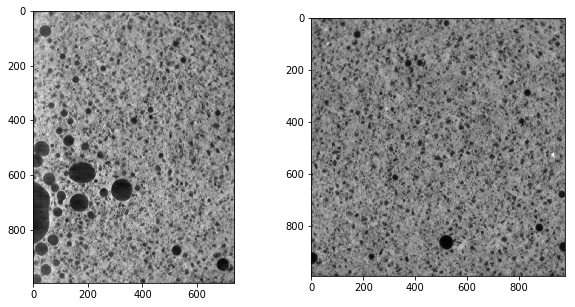

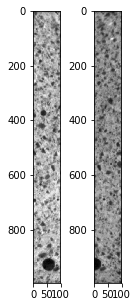

In [8]:
left_index = 33
right_index = 40

image_left, image_right = find_corresponding_index(data_left, data_right, left_index, right_index)

### Histogram matching

c:\program files\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


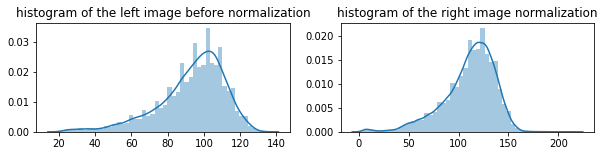

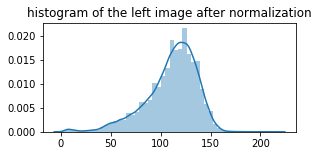

In [9]:
image_left = histogram_matching(image_left, image_right)

### Image registration

c:\program files\python36\lib\site-packages\skimage\measure\fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


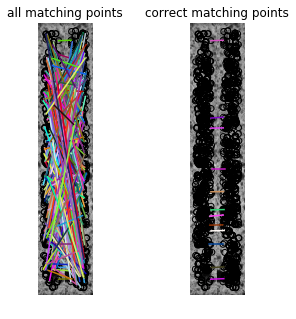

In [10]:
model_robust=image_registration(image_left, image_right)

### Stitch the small ROI

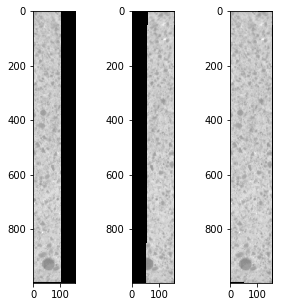

In [11]:
image_merge = merge_small_img(image_left, image_right, model_robust)

### Merge the full image

array([[-0.54509804, -0.54117647, -0.54117647, ..., -2.        ,
        -2.        , -2.        ],
       [-0.5372549 , -0.5372549 , -0.53333333, ..., -2.        ,
        -2.        , -2.        ],
       [-0.5372549 , -0.52941176, -0.54117647, ..., -2.        ,
        -2.        , -2.        ],
       ...,
       [-2.        , -2.        , -2.        , ..., -2.        ,
        -2.        , -2.        ],
       [-2.        , -2.        , -2.        , ..., -2.        ,
        -2.        , -2.        ],
       [-2.        , -2.        , -2.        , ..., -2.        ,
        -2.        , -2.        ]])

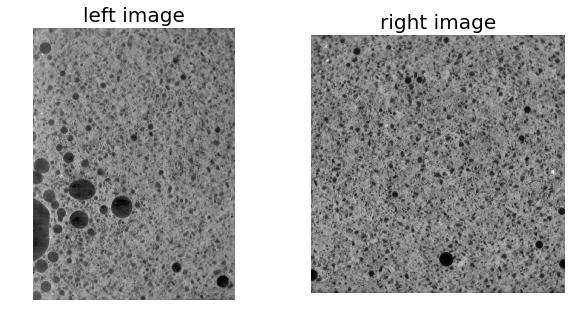

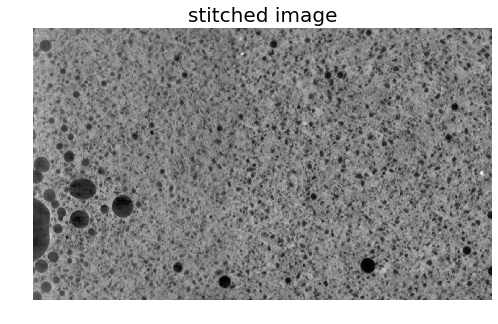

In [12]:
merge_full_image(data_left, data_right, left_index, right_index, model_robust, verbose = 1, hist_match = 1)


### Match the histogram arocess the whole volumn

In [13]:
#data_left = histogram_match_vol(data_left[:,100:,:],data_right) 
#crop part of the left volumn as the extra one is differnt

### check if the same registation model work for other frame

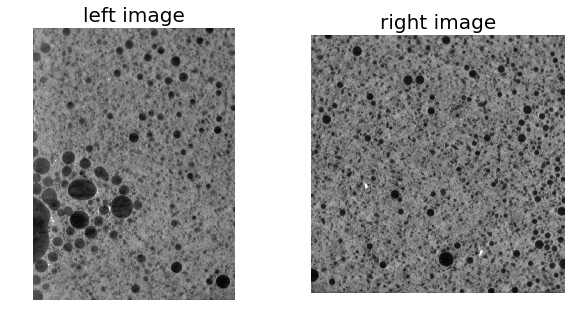

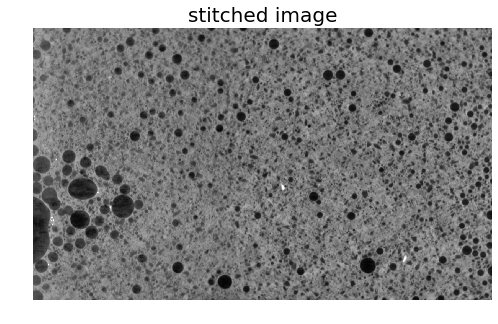

In [14]:
image_merge = merge_full_image(data_left, data_right, left_index+10, right_index+10, model_robust, verbose = 1, hist_match = 1)

### Merge the whole volumn

(995, 737, 76)
(995, 977, 76)
(995, 737, 76)
(995, 977, 70)
stitched volumn has shape: (1003, 1658, 70)


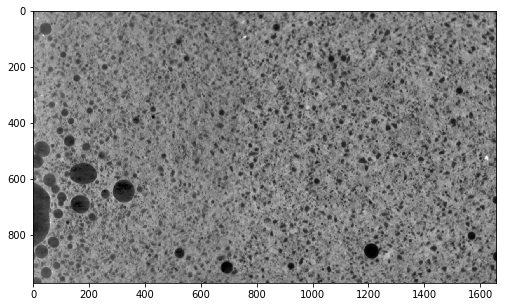

In [15]:
vol_merge = merge_vol(left_index, right_index, data_left, data_right, model_robust, image_merge)

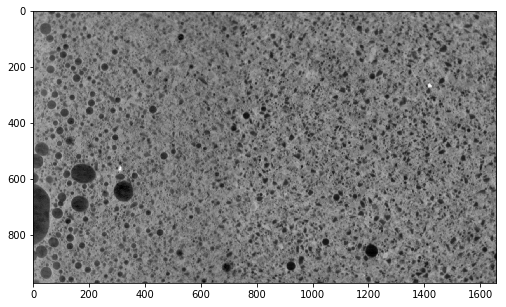

In [17]:
plt.figure(figsize = (20,5))
plt.imshow(vol_merge[10:-20,:,26], cmap = 'gray')